In [5]:
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
transform = transforms.ToTensor()

In [7]:
train_df = MNIST(root = '/data', download = False, transform=transform)

In [8]:
test_df = MNIST(root='/data', download = False, train = False, transform = transform)

In [9]:
batch_size = 128
train_dl = DataLoader(train_df, batch_size = batch_size, shuffle = True, num_workers=2, pin_memory=True )
test_dl = DataLoader(train_df, batch_size = batch_size, num_workers=2, pin_memory=True )

In [10]:
def make_grid_images(dataloader):
  for batch in dataloader:
    images, labels = batch
    plt.figure(figsize=(10,16))
    plt.imshow(make_grid(images, nrow = 16).permute(1,2,0))
    plt.axis('off')
    break


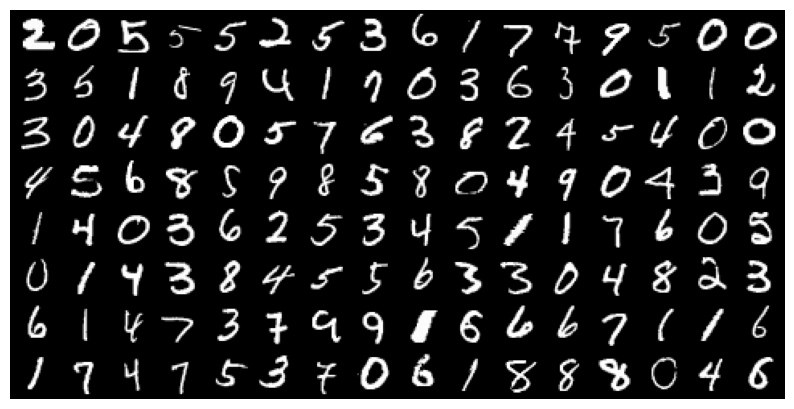

In [11]:
make_grid_images(train_dl)

In [12]:
class Convolutional_AE(nn.Module):
  def __init__(self):
    super(Convolutional_AE, self).__init__()
    self.encoder = nn.Sequential( # 1 x 28 x 28
                                  nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, stride = 2, padding = 1),
                                  # 16 x 14 x 14
                                  nn.ReLU(),
                                  # nn.BatchNorm2d(16),
                                  nn.Conv2d(16,32, 3, 2, 1),
                                  #  32 x 7 x 7
                                  nn.ReLU(),
                                  # nn.BatchNorm2d(32),
                                  nn.Conv2d(32,64, 7))
                                  # 64 x 1 x 1
    self.decoder = nn.Sequential(
                                      nn.ConvTranspose2d(64 , 32, 7),
                                      nn.ReLU(),
                                      # nn.BatchNorm2d(32),
                                      #  32 x 7 x 7
                                      nn.ConvTranspose2d( 32, 16, 3, 2, 1, output_padding=1),
                                      #  16 x 14 x 14
                                      nn.ReLU(),
                                      # nn.BatchNorm2d(16),
                                      nn.ConvTranspose2d(16 , 1, 3, 2, 1, output_padding = 1 ),
                                      nn.Sigmoid())

                                      #  1 x 28 x 28

  def forward (self, x):
    encodings = self.encoder(x)
    decodings = self.decoder(encodings)
    return encodings , decodings

In [13]:
model = Convolutional_AE()
model

Convolutional_AE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [14]:
def fit(model, lr, num_epochs, train_dl, optim_func = torch.optim.Adam):
  optimizer = optim_func(model.parameters(), lr)
  epoch_losses = []
  outputs = []
  print('Starting Epochs')
  for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in train_dl:
      images,_ = batch
      encodings, decodings = model(images)
      loss = F.mse_loss(decodings, images)
      epoch_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    epoch_loss /= len(train_dl)
    epoch_losses.append(epoch_loss)
    outputs.append((epoch, encodings, decodings, images))
    print(f'epoch:{epoch+1}, loss: {epoch_loss :.4f}')
  return epoch_losses, outputs


In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
print(device)

cuda


In [17]:
train_dl = DeviceDataLoader(train_dl, device)
model = to_device(model, device)

In [18]:
lr = 1e-3
num_epochs = 15
epoch_losses, output_list = fit(model = model, lr = lr, num_epochs = num_epochs, train_dl = train_dl)

Starting Epochs
epoch:1, loss: 0.0493
epoch:2, loss: 0.0097
epoch:3, loss: 0.0061
epoch:4, loss: 0.0048
epoch:5, loss: 0.0041
epoch:6, loss: 0.0036
epoch:7, loss: 0.0033
epoch:8, loss: 0.0031
epoch:9, loss: 0.0029
epoch:10, loss: 0.0028
epoch:11, loss: 0.0027
epoch:12, loss: 0.0026
epoch:13, loss: 0.0025
epoch:14, loss: 0.0024
epoch:15, loss: 0.0024


Text(0.5, 1.0, 'Losses VS Epochs')

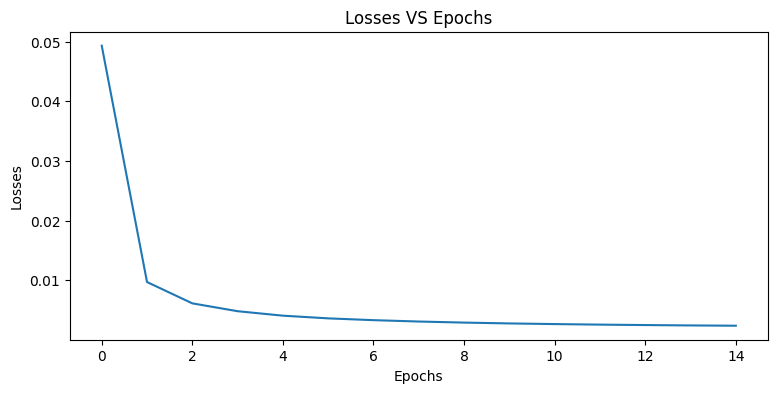

In [21]:
plt.figure(figsize=(9,4))
plt.plot(epoch_losses)
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Losses VS Epochs')


In [49]:
def show_images(output_list, index_1,index_2):
  imgs = output_list[index_1][index_2].cpu().detach().numpy()
  print(f'output shape is>>> {imgs.shape}')
  imgs=imgs.reshape(-1,28,28)
  print(f'reshaped output shape is>>> {imgs.shape}')
  plt.figure(figsize=(9,3))
  for i in range(1,28):
    plt.subplot(3, 9, i)
    plt.imshow(imgs[i - 1])
    i +=1


output shape is>>> (96, 1, 28, 28)
reshaped output shape is>>> (96, 28, 28)


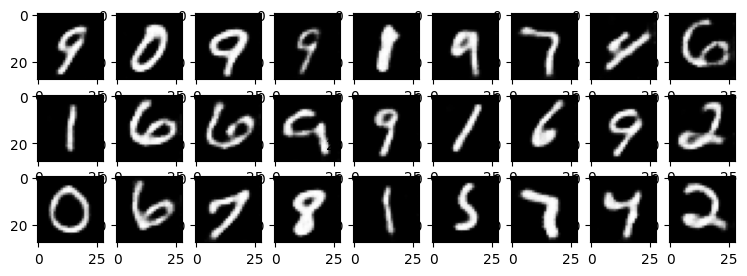

In [50]:
show_images(output_list,1,2)

output shape is>>> (96, 1, 28, 28)
reshaped output shape is>>> (96, 28, 28)


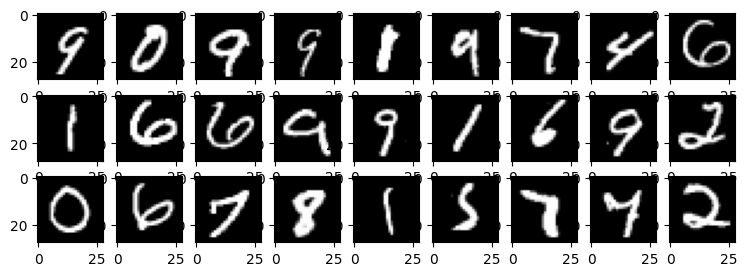

In [51]:
show_images(output_list,1,3)

In [69]:
test_dl = DeviceDataLoader(test_dl,device)

In [91]:
model.eval()
for batch in test_dl:
      test_images,_ = batch
      encodings, decodings = model(test_images)
      loss = F.mse_loss(decodings, test_images)
      print(loss.item())
      break

0.002324824221432209


In [92]:
decodings = decodings.cpu().detach().numpy()
test_images = test_images.cpu().detach().numpy()
encodings = encodings.cpu().detach().numpy()


reshaped output shape is>>> (128, 28, 28)
reshaped output shape is>>> (128, 28, 28)


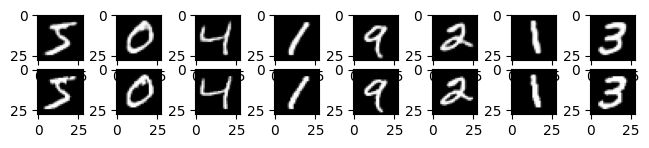

In [94]:
decodings=decodings.reshape(-1,28,28)
print(f'reshaped output shape is>>> {decodings.shape}')
plt.figure(figsize=(9,2))
for i in range(1,9):
  plt.subplot(3, 9, i)
  plt.imshow(decodings[i - 1])
  i +=1


test_images=test_images.reshape(-1,28,28)
print(f'reshaped output shape is>>> {test_images.shape}')
for i in range(1,9):
  plt.subplot(3, 9, i+9)
  plt.imshow(test_images[i - 1])
  i +=1